# Age Regression from Pictures

In this notebook you will set up regression models outputs a gaussian conditional probability distribution.
You will model the conditional probability distribution $p(y|x)$ as a Normal distribution.

**Dataset:**
You work with a the [UTKFace dataset](https://susanqq.github.io/UTKFace/). It has a large age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprocessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age and image.


**GPU:**
It is better to use the GPU for this notebook. If you are using colab, you can change the runtime type in the menu: Runtime -> Change runtime type -> Hardware accelerator -> GPU.

**Your Task**
Steps through the notebook and try to understand the code. The code is already quite complete, fill out the cells with (🔧 YOUR TASK)

#### Settings

A negative number of EPOCHS loads the trained weights.

In [1]:
EPOCHS = -100   #Change this to smaller number for testing, negative means load the weights from dropbox (only for JAX)
# Note only tested for JAX backend
BACKEND = 'JAX' #Change this to 'JAX' or 'TORCH' 

In [2]:
### Running on Colab
import sys
import time
IN_COLAB = 'google.colab' in sys.modules
print(f"Running on Colab: {IN_COLAB}")

Running on Colab: False


##### Setting the backend

In [3]:
import os
################## Keras with PyTorch Backend ################
if (BACKEND == 'TORCH'):
  # Set Keras backend to PyTorch
  # os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
  os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!
  import torch
  from torch.distributions import Normal
  cuda_available = torch.cuda.is_available()
  cuda_version = torch.version.cuda if cuda_available else "N/A"
  print(f"CUDA Available: {cuda_available}")
  print(f"CUDA Version: {cuda_version}")

################## Keras with JAX Backend ################
if (BACKEND == 'JAX'):
  if (IN_COLAB): #Currently December 2024 numpyro needs to be installed manually
    start_time = time.time()
    %pip install numpyro
    end_time = time.time()
    print(f"Time taken to install numpyro: {(end_time - start_time):.2f} seconds")
  # Set Keras backend to JAX
  os.environ["KERAS_BACKEND"] = "jax" # Before importing Keras!
  import jax
  from jax import random
  from numpyro import distributions as dist
  import jax.numpy as jnp
  print(f"jax.__version__ {jax.__version__}")
  cuda_available = any(device.platform == 'gpu' for device in jax.devices())
  # Attempt to get CUDA version info (platform_version often includes CUDA info)
  print(f"jax.devices() {jax.devices()}")
  # get GPU Name
  if (cuda_available):
    print(f"jax.devices()[0].device_kind {jax.devices()[0].device_kind}")
    

import keras
print(keras.__version__)
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")

jax.__version__ 0.4.26
jax.devices() [CpuDevice(id=0)]
3.6.0
Keras version: 3.6.0
Backend: jax


In [4]:
##### We import Keras (after setting the backend)
from keras import layers, Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
import keras.backend as K


import numpy as np

import urllib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from tqdm.keras import TqdmCallback # train the model

#### Loading the data, if it is not loaded

In [5]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")
!ls -lh X_face*

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")
!ls -lh Y*

-rw-r--r--@ 1 oli  staff   434M Jan  7 13:25 X_faces.npy


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


-rw-r--r--@ 1 oli  staff    93K Jan  7 13:25 Y_age.npy


In [7]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at a few image samples

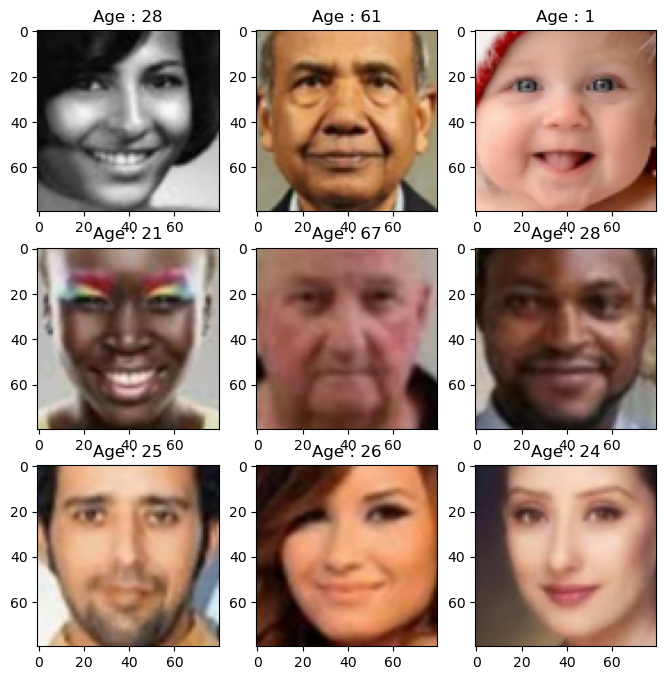

In [9]:
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))

#### Normalize the data

In [10]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the age distribution

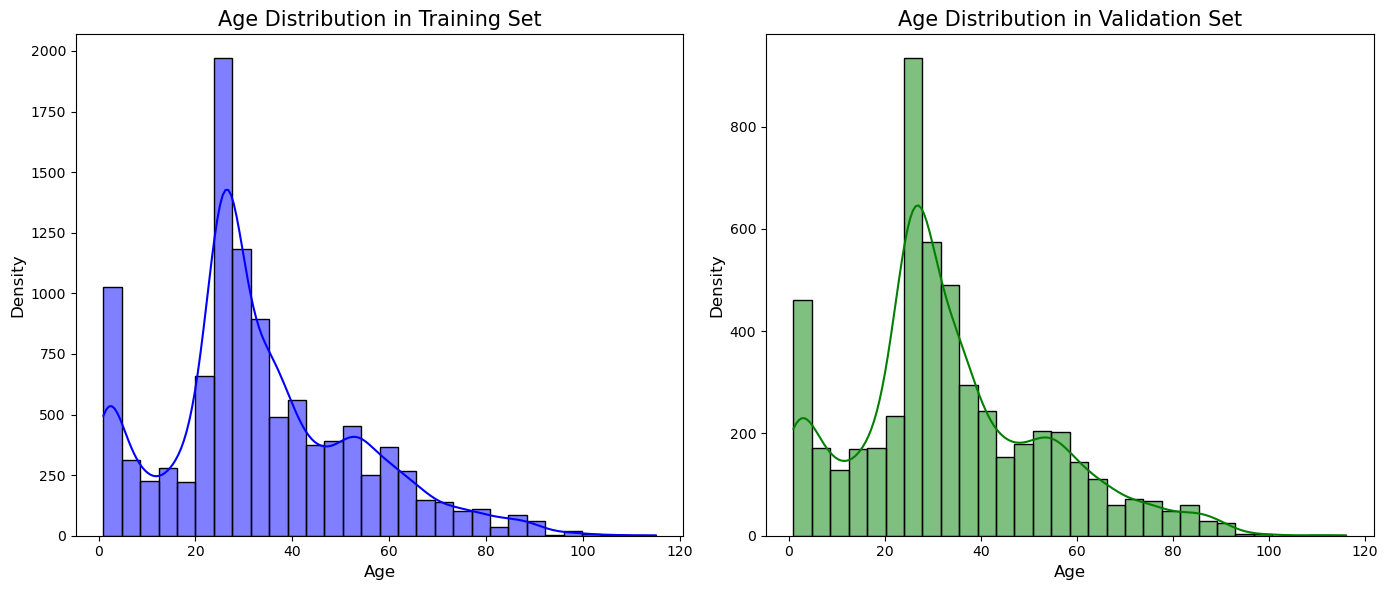

In [11]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(y_train, bins=30, kde=True, color='blue')
plt.title("Age Distribution in Training Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(1,2,2)
sns.histplot(y_val, bins=30, kde=True, color='green')
plt.title("Age Distribution in Validation Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

#### 🔧 **Exercise 1:** implement Naive Model

Use a naive model, which simply predicts a Gaussian w/o using the images at all. To solve the task you have to estimate the values for $\mu$ and $\sigma$ of the Gaussian $N(\mu,\sigma)$. 

##### i) Estimation of $\mu$ and $\sigma$
You should get $\hat{\mu} \approx 33.14$ and $\hat{\sigma} \approx 19.81$.

##### ii) Calculate the NLL on the testset.

In [2]:
#### 🔧 YOUR TASK ########


#### ⚠️ Preparing Data for Backend ⚠️


Note that the reshape is extremly important. This makes the shape of y from $(B,)$ to $(B,1)$ a shape of $(B,)$ will cause strange broadcast errors. To check remove the reshape and train again.

In [14]:
#We only need float32
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

##### NOTE THE RESHAPE IS EXTREMLY IMPORTANT ####
y_train = np.array(y_train,dtype="float32").reshape(-1,1) #⚠️ w/o reshape no training beyond naive model
y_val = np.array(y_val,dtype="float32").reshape(-1,1)     #⚠️
y_test = np.array(y_test,dtype="float32").reshape(-1,1)   #⚠️

if (K.backend() == 'torch'):
  X_train = torch.tensor(X_train).float()
  X_val = torch.tensor(X_val).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(y_train).float()
  y_val = torch.tensor(y_val).float()
  y_test = torch.tensor(y_test).float()

print(X_train.mean())
print(X_val.mean())
print(X_val.mean())

print(y_train.shape) #Need to have the last dimension of ,1

0.47795781
0.4774688
0.4774688
(10642, 1)


### Output of NN to Gaussian Distribution

The output NN has the form (B, 2) with the first dimension. The last two dimensions code the mean and the log(sd) of the Gaussian.

In [15]:
# Wrapper function to convert model output to a PyTorch Normal distribution
if (K.backend() == 'torch'):
  print('Using PyTorch specific code')
  from torch import nn
  import torch
  from torch.distributions import Normal

  @staticmethod
  def output_to_gaussian_distribution(output):
      mean = output[:, :1]
      log_variance = output[:, 1:]
      scale = torch.exp(log_variance)  # Ensure positive scale
      return torch.distributions.Normal(loc=mean, scale=scale)

if (K.backend() == 'jax'):
  print('Using JAX specific code')
  from numpyro import distributions as dist

  @staticmethod
  def stable_softplus(x):
    return jnp.where(x > 20, x, jnp.log(1 + jnp.exp(x)))

  @staticmethod
  def output_to_gaussian_distribution(out):
      mean = out[:, :1]       # first column is mean
      log_sd = out[:, 1:]    # last column is log variance
      #scale = 1e-3 + stable_softplus(0.05 * out[:, 1:])  # Apply stable softplus to log scale
      scale = jnp.exp(log_sd)
      return dist.Normal(mean, scale)

def NLL(y_true, output):
  dist = output_to_gaussian_distribution(output)
  return -dist.log_prob(y_true).mean()

Using JAX specific code


#### Investigating the output distribution and explanation an
 subtle error

For a detailed description of the bug see: https://github.com/tensorchiefs/dl_keras3/blob/main/notebooks/probabilistic_modelling/batching_gradient_problem.ipynb

out.shape (3, 2)
(3,)
1.7281334


👎 shape of y(3,)
grad of NLL [-0.02777778 -0.02777778 -0.02777778]


👍 shape of y(3, 1)
grad of NLL [[ 0.        ]
 [ 0.        ]
 [-0.08333334]]


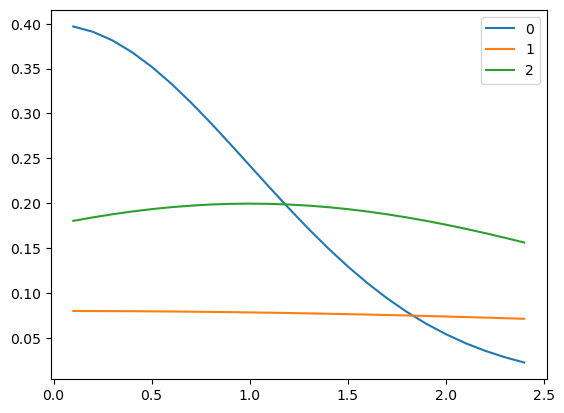

In [16]:
out = np.array([
    [0,np.log(1)],
    [0,np.log(5)],
    [1,np.log(2)]
])

xs = np.arange(0.1,2.5,0.1)

if (K.backend() == 'torch'):
  print('Using PyTorch specific code')
  out = torch.tensor(out)
  xs = torch.tensor(xs)

print(f"out.shape {out.shape}")
outdist = output_to_gaussian_distribution(out)
outdist.mean

outdist.log_prob(xs).shape
for i in range(3):
  plt.plot(xs, np.exp(outdist.log_prob(xs))[i], label=str(i))
plt.legend()
#plt.show()

yy = np.zeros((3))
if (K.backend() == 'torch'):
  yy = torch.tensor(yy)

print(yy.shape)
print(NLL(yy, out))

if (K.backend() == 'jax'):
  print("\n")
  print(f"👎 shape of y{yy.shape}\ngrad of NLL {jax.grad(NLL)(yy, out)}")
  yy = yy.reshape(-1,1)
  print("\n")
  print(f"👍 shape of y{yy.shape}\ngrad of NLL {jax.grad(NLL)(yy, out)}")
  yy = np.zeros((3,))
  jax.grad(NLL)(yy, out)

## Fit a regression model with flexible variance
In the next cells you will again define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [17]:
kernel_size = (3, 3)
pool_size = (2, 2)
input1 = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten(name = 'bef_split')(x)

# One HEAD
#x = Dense(2*500, activation="relu")(x)
#x = Dropout(0.3)(x)
#x = Dense(2*50, activation="relu")(x)
#x = Dropout(0.3)(x)
#mean_and_sd_layer = Dense(2)(x)

#### TWO HEAD
##### SIGMA HEAD
x_sd = Dense(500, activation="relu")(x)
x_sd = Dropout(0.3)(x_sd)
x_sd = Dense(50, activation="relu")(x_sd)
x_sd = Dropout(0.3)(x_sd)
x_sd = Dense(1)(x_sd)
### MEAN_HEAD
x_mu = Dense(500, activation="relu")(x)
x_mu = Dropout(0.3)(x_mu)
x_mu = Dense(50, activation="relu")(x_mu)
x_mu = Dropout(0.3)(x_mu)
x_mu = Dense(1)(x_mu)
### Concatinate
mean_and_sd_layer = Concatenate()([x_mu, x_sd])


model_flex = Model(inputs=input1, outputs=mean_and_sd_layer)
model_flex.compile(keras.optimizers.Adam(), loss=NLL)
model_flex.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 40, 40,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 20, 20,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 10,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bef_split (Flatten) │ (None, 3200)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 500)       │  1,600,500 │ bef_split[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 500)       │  1,600,500 │ bef_split[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 50)        │     25,050 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │     25,050 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         51 │ dropout_3[0][0] 

 Total params: 3,286,354 (12.54 MB)

 Trainable params: 3,286,354 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
if (EPOCHS > 0):
  history=model_flex.fit(X_train, y_train,
                      epochs=EPOCHS,
                      verbose=0,
                      validation_data=(X_val, y_val),
                      callbacks=[TqdmCallback(verbose=1)]
                    )
  model_flex.save_weights('model_flex.weights.h5')
  # Save history files
  with open('history.pkl', 'wb') as f:
      pickle.dump(history.history, f)
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.axhline(y=nll_naive, color='r', linestyle='--', label='Naive NLL')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.ylim(0, 7)
  plt.legend()
  plt.show()
else:
    print("Downloading weights ...")
    import requests
    # Define the URL and the local file path
    url = 'https://www.dropbox.com/scl/fi/7lgbkld4u55b70kt5rwqz/model_flex.weights.h5?rlkey=oxf9g4cyfit3pjuu71t2sltlb&dl=1'
    local_file = 'model_flex.weights.h5'

    # Check if the file already exists
    if not os.path.exists(local_file):
        # Download the file if it does not exist
        response = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(response.content)

    # Load the weights from the local file
    model_flex.load_weights(local_file)

/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Look at the predicted mean and the predicted sigma of the CPD on the testset


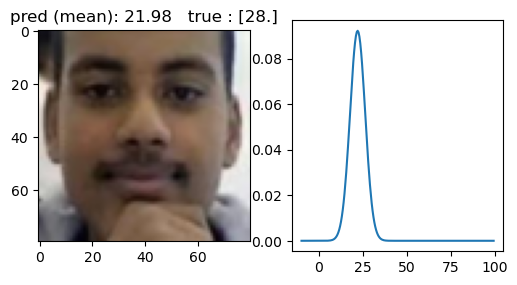

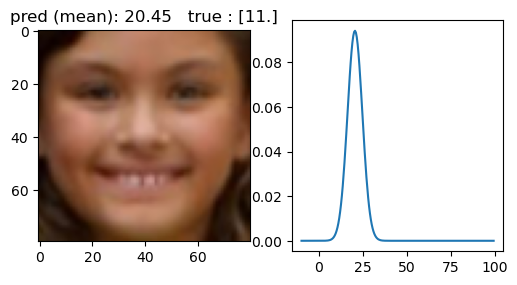

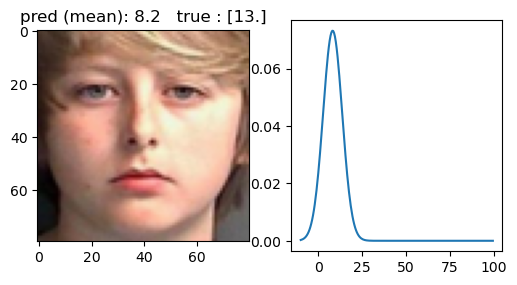

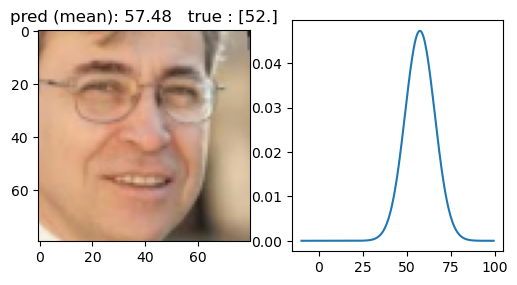

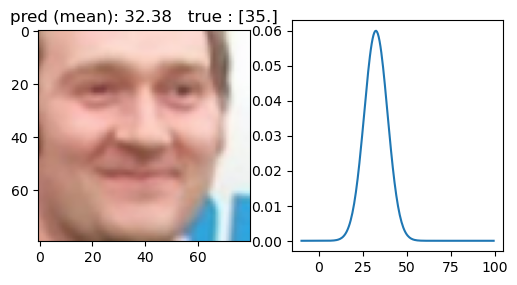

In [19]:
ages = np.arange(-1,100,0.5)

for i in range(0,5):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu_sigma = model_flex(X_test[i:i+1])
    mu = mu_sigma[0, 0]
    sigma = np.exp(mu_sigma[0, 1])

    plt.title("pred (mean): "+ str(round(float(mu), 2)) +
            "   true : "+ str(y_test[i]))
    d = dist.Normal(loc=mu, scale=sigma)
    plt.subplot(1,2,2)
    ys = jnp.arange(-10,100,0.5)
    plt.plot(ys, np.exp(d.log_prob(ys)))
    plt.show()

# 🔧 Exercise 2 (Calculate Model Preformance)

Calculate the NLL for the testset. For that write a function that has the API of a score. The function should take the observed/true `y_observed` values and the predicted CPD $p_{\tt{pred}}(y|x)$ as input (called `py_given_x`) and return the NLL. Here is the core of the function:

```python
def score(py_given_x, y_observed):
    # py_given_x: the predicted CPD as a tfp.distributions object
    # y_observed: the observed/true values
    # return: Score (lower is better forecast)
    # YOUR CODE HERE
```

Which other scores/metrics could you use to compare the models, which once should you not use?

For partical reasons the network needs to be transformed to a distribution, using the function `output_to_gaussian_distribution`. This function is already implemented in the notebook.

```python
def NLL(out_network, y):
    dist = output_to_gaussian_distribution(out_network)
    ... YOUR CODE HERE ...
```

### Solution to the exercise (remove this code)

# 🔧 Exercise 3 (Find most certain preds)
Find the 5 person of the test set the model is most certain about and plot the together with the predicted CPD.

# 🔧 Exercise 4 (PIT-histogram)

Create a so-called PIT histgram (Probability Integral Transform) to check if the model is calibrated. For that take calculate the values of the cumulative distribution function (CDF) of the predicted distribution evaluated at the observed ages. Then plot a histogram of these values. The histogram should be uniform if the model is calibrated. Describe your findings.


Hint: You can use the function `scipy.stats.norm.cdf` to calculate the CDF of the normal distribution.

# Suggestion for further exercises (optional)

The gausian distribution is not the best distribution to model the age. For example the [Log-Normal](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LogNormal). This would give you a model that is not able to predict negative ages. And the result would look like:


![Screenshot 2024-01-07 at 15.13.51.png](imgs/img1.png)

and
![Screenshot 2024-01-07 at 15.13.39.png](imgs/img2.png))
